In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from tqdm import tqdm

### v1

In [ ]:
class ReorderRateClassificationModel:
    def __init__(
        self,
        user_id=int,
        orders_df=pd.DataFrame,
        order_products_df=pd.DataFrame,
        top_reodered_items_n: int = 10,
    ):
        self.top_reordered_items_n = top_reodered_items_n

        self._get_orders(orders_df)
        self._get_order_products(order_products_df)

        self.user_id = user_id
        self._get_user_features(self.user_id)

        self._get_products_features()

    def _get_orders(self, orders_df: pd.DataFrame):
        self.orders = orders_df  # меняется на запрос

    def _get_order_products(self, order_products_df: pd.DataFrame):
        self.orders_products = order_products_df  # меняется на запрос

    def _get_last_order_products(self, user_id: int) -> pd.Series:
        prior_orders = self.orders[self.orders["eval_set"] == "prior"]
        prior_user_orders = prior_orders[self.orders["user_id"] == user_id]

        if prior_user_orders.empty:
            return pd.Series([], dtype=int)

        last_prior_user_order_id = prior_user_orders.loc[
            prior_user_orders["order_number"].idxmax(), "order_id"
        ]
        last_order_products = self.orders_products[
            self.orders_products["order_id"] == last_prior_user_order_id
        ]["product_id"]

        return last_order_products

    def _get_top_reordered_items(self) -> pd.Series:
        products_agg = (
            self.orders_products.groupby("product_id")
            .agg(
                {
                    "reordered": "mean",
                }
            )
            .rename(
                columns={
                    "reordered": "product_reorder_rate",
                }
            )
        )
        products_agg.reset_index(inplace=True)

        top_reordered_items = products_agg.sort_values(
            by="product_reorder_rate", ascending=False
        )[: self.top_reordered_items_n]

        return top_reordered_items["product_id"]

    def _get_products_features(self):
        self.df_products_features = pd.DataFrame()

        top_reordered_items = self._get_top_reordered_items().values
        self.df_products_features["top_reordered"] = top_reordered_items

    def _get_user_features(self, user_id: int):
        self.df_user_features = pd.DataFrame()

        last_order_products = self._get_last_order_products(user_id).values
        self.df_user_features["last_user_order"] = last_order_products

    def predict(self, product_id: int, user_id: int = None):
        # Меняется на
        #     features = self.get_features(user_id. product_id)
        #     return lgb_model.predict(features)

        if user_id is not None:
            self.user_id = user_id
            self._get_user_features(self.user_id)

        if product_id in self.df_user_features["last_user_order"].values:
            return True

        if product_id in self.df_products_features["top_reordered"].values:
            return True

        return False

In [ ]:
data_path = "../data/"

orders_df = pd.read_csv(data_path + "orders.csv")
order_products_df = pd.read_csv(data_path + "order_products__prior.csv")

In [ ]:
clf_model = ReorderRateClassificationModel(
    user_id=1, orders_df=orders_df, order_products_df=order_products_df
)

In [ ]:
clf_model.predict(6433)

In [ ]:
class ReorderRateRecommendationModel:
    def __init__(
        self,
        user_id=int,
        orders_df=pd.DataFrame,
        order_products_df=pd.DataFrame,
        top_reodered_items_n: int = 10,
    ):
        self.user_id = user_id

        self.clf_model = ReorderRateClassificationModel(
            user_id, orders_df, order_products_df, top_reodered_items_n
        )

    def predict(self):
        recommendations_list = []
        products_id = self.clf_model.orders["order_id"].values
        for product_id in tqdm(products_id):
            pred = self.clf_model.predict(product_id)
            if pred:
                recommendations_list.append(product_id)

        return np.random.choice(
            recommendations_list, size=clf_model.top_reordered_items_n, replace=False
        )

In [ ]:
rec_model = ReorderRateRecommendationModel(
    user_id=1, orders_df=orders_df, order_products_df=order_products_df
)

In [ ]:
rec_model.predict()


### v2

In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd

IDIR = "../data/"

Загрузка таблиц (меняется на запросы к бд)

In [2]:
def get_data():
    priors = pd.read_csv(
        IDIR + "order_products__prior.csv",
        dtype={
            "order_id": np.int32,
            "product_id": np.uint16,
            "add_to_cart_order": np.int16,
            "reordered": np.int8,
        },
    )

    print("loading train")
    train = pd.read_csv(
        IDIR + "order_products__train.csv",
        dtype={
            "order_id": np.int32,
            "product_id": np.uint16,
            "add_to_cart_order": np.int16,
            "reordered": np.int8,
        },
    )

    print("loading orders")
    orders = pd.read_csv(
        IDIR + "orders.csv",
        dtype={
            "order_id": np.int32,
            "user_id": np.int32,
            "eval_set": "category",
            "order_number": np.int16,
            "order_dow": np.int8,
            "order_hour_of_day": np.int8,
            "days_since_prior_order": np.float32,
        },
    )

    print("loading products")
    products = pd.read_csv(
        IDIR + "products.csv",
        dtype={
            "product_id": np.uint16,
            "order_id": np.int32,
            "aisle_id": np.uint8,
            "department_id": np.uint8,
        },
        usecols=["product_id", "aisle_id", "department_id"],
    )

    print("priors {}: {}".format(priors.shape, ", ".join(priors.columns)))
    print("orders {}: {}".format(orders.shape, ", ".join(orders.columns)))
    print("train {}: {}".format(train.shape, ", ".join(train.columns)))

    return priors, train, orders, products

In [3]:
priors, train, orders, products = get_data()

loading train
loading orders
loading products
priors (32434489, 4): order_id, product_id, add_to_cart_order, reordered
orders (3421083, 7): order_id, user_id, eval_set, order_number, order_dow, order_hour_of_day, days_since_prior_order
train (1384617, 4): order_id, product_id, add_to_cart_order, reordered


Добавление информации об orders в prior

In [4]:
def extend_priors(priors, orders):
    orders.set_index("order_id", inplace=True, drop=False)
    priors = priors.join(orders, on="order_id", rsuffix="_")
    priors.drop("order_id_", inplace=True, axis=1)

    return priors

In [5]:
priors = extend_priors(priors, orders)

In [6]:
priors

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0
...,...,...,...,...,...,...,...,...,...,...
32434484,3421083,39678,6,1,25247,prior,24,2,6,21.0
32434485,3421083,11352,7,0,25247,prior,24,2,6,21.0
32434486,3421083,4600,8,0,25247,prior,24,2,6,21.0
32434487,3421083,24852,9,1,25247,prior,24,2,6,21.0


Фичи продуктов

In [7]:
def get_product_features(priors, products):
    prods = pd.DataFrame()
    prods["orders"] = priors.groupby(priors.product_id).size().astype(np.int32)
    prods["reorders"] = (
        priors["reordered"].groupby(priors.product_id).sum().astype(np.float32)
    )
    prods["reorder_rate"] = (prods.reorders / prods.orders).astype(np.float32)
    products = products.join(prods, on="product_id")
    products.set_index("product_id", drop=False, inplace=True)
    del prods

    return products

In [8]:
products = get_product_features(priors, products)

In [9]:
products

,product_id,aisle_id,department_id,orders,reorders,reorder_rate
product_id,,,,,,
1,1,61,19,1852.0,1136.0,0.613391
2,2,104,13,90.0,12.0,0.133333
3,3,94,7,277.0,203.0,0.732852
4,4,38,1,329.0,147.0,0.446809
5,5,5,13,15.0,9.0,0.600000
...,...,...,...,...,...,...
49684,49684,124,5,9.0,1.0,0.111111
49685,49685,42,1,49.0,6.0,0.122449
49686,49686,112,3,120.0,84.0,0.700000


Фичи пользователей

In [10]:
def get_user_features(priors, orders):
    usr = pd.DataFrame()
    usr["average_days_between_orders"] = (
        orders.groupby("user_id")["days_since_prior_order"].mean().astype(np.float32)
    )
    usr["nb_orders"] = orders.groupby("user_id").size().astype(np.int16)

    users = pd.DataFrame()
    users["total_items"] = priors.groupby("user_id").size().astype(np.int16)
    users["all_products"] = priors.groupby("user_id")["product_id"].apply(set)
    users["total_distinct_items"] = (users.all_products.map(len)).astype(np.int16)

    users = users.join(usr)
    del usr

    users["average_basket"] = (users.total_items / users.nb_orders).astype(np.float32)

    return users

In [11]:
users = get_user_features(priors, orders)

In [12]:
users

,total_items,all_products,total_distinct_items,average_days_between_orders,nb_orders,average_basket
user_id,,,,,,
1,59,"{17122, 196, 26405, 46149, 14084, 13032, 26088...",18,19.000000,11,5.363636
2,195,"{45066, 2573, 18961, 23, 32792, 1559, 22559, 1...",102,16.285715,15,13.000000
3,88,"{17668, 44683, 48523, 21903, 14992, 21137, 324...",33,12.000000,13,6.769231
4,18,"{21573, 42329, 17769, 35469, 37646, 1200, 1905...",17,17.000000,6,3.000000
5,37,"{11777, 40706, 28289, 48775, 20754, 6808, 1398...",23,11.500000,5,7.400000
...,...,...,...,...,...,...
206205,32,"{20995, 21137, 22035, 21910, 17691, 31404, 210...",24,16.666666,4,8.000000
206206,285,"{16896, 44033, 18434, 16387, 21508, 45573, 102...",150,3.716418,68,4.191176
206207,223,"{20995, 18441, 45578, 47626, 33806, 22035, 235...",92,14.312500,17,13.117647


Фичи пользователь-продукт

In [13]:
def get_userXproduct_features(priors):
    priors["user_product"] = priors.product_id + priors.user_id * 100000

    d = dict()
    for row in priors.itertuples():
        z = row.user_product
        if z not in d:
            d[z] = (1, (row.order_number, row.order_id), row.add_to_cart_order)
        else:
            d[z] = (
                d[z][0] + 1,
                max(d[z][1], (row.order_number, row.order_id)),
                d[z][2] + row.add_to_cart_order,
            )

    userXproduct = pd.DataFrame.from_dict(d, orient="index")
    del d

    userXproduct.columns = ["nb_orders", "last_order_id", "sum_pos_in_cart"]
    userXproduct.nb_orders = userXproduct.nb_orders.astype(np.int16)
    userXproduct.last_order_id = userXproduct.last_order_id.map(lambda x: x[1]).astype(
        np.int32
    )
    userXproduct.sum_pos_in_cart = userXproduct.sum_pos_in_cart.astype(np.int16)
    print("user X product f", len(userXproduct))

    del priors

    return userXproduct

In [14]:
userXproduct = get_userXproduct_features(priors)

user X product f 13293564


In [16]:
userXproduct

,nb_orders,last_order_id,sum_pos_in_cart
-1246903360,5,104690,10
-1246907495,5,132412,16
-1246927153,1,2,3
-1246890562,5,2382766,24
-1246906445,3,2382766,14
...,...,...,...
-1770221987,1,3421083,2
-1770246134,1,3421083,3
-1770232085,1,3421083,5
-1770255944,1,3421083,7


Формирование датасета

In [17]:
def get_all_pairs(
    selected_orders,
    orders,
    users,
    train,
    labels_given=False,
    drop_orders=True,
):
    order_list = []
    product_list = []
    labels = []
    i = 0

    for row in selected_orders.itertuples():
        i += 1
        if i % 10000 == 0:
            print("order row", i)
        order_id = row.order_id
        user_id = row.user_id
        user_products = users.all_products[user_id]
        product_list += user_products
        order_list += [order_id] * len(user_products)

        # Формирование таргета (1 если продукт есть в истории заказов пользователя, 0 - иначе)

        if labels_given:
            labels += [(order_id, product) in train.index for product in user_products]

    # Создание датафрейма с номерами заказов и всеми продуктами, которые заказывал пользователь, относящийся к этому заказу

    pairs_df = pd.DataFrame(
        {"order_id": order_list, "product_id": product_list}, dtype=np.int32
    )
    labels = np.array(labels, dtype=np.int8)
    del order_list
    del product_list

    pairs_df["user_id"] = pairs_df.order_id.map(orders.user_id)

    columns = ["user_id", "product_id"]
    if not drop_orders:
        columns += ["order_id"]

    return pairs_df[columns], labels

In [18]:
def get_all_features(
    df,
    orders,
    userXproduct,
    users,
    products,
):
    # Добавление фичей пользователя (из users) 

    df["user_total_orders"] = df.user_id.map(users.nb_orders)
    df["user_total_items"] = df.user_id.map(users.total_items)
    df["total_distinct_items"] = df.user_id.map(users.total_distinct_items)
    df["user_average_days_between_orders"] = df.user_id.map(
        users.average_days_between_orders
    )
    df["user_average_basket"] = df.user_id.map(users.average_basket)

    # Добавления фичей заказа (из orders)

    # df['dow'] = df.order_id.map(orders.order_dow)
    # df["order_hour_of_day"] = df.order_id.map(orders.order_hour_of_day)
    # df["days_since_prior_order"] = df.order_id.map(orders.days_since_prior_order)
    # df["days_since_ratio"] = (
    #     df.days_since_prior_order / df.user_average_days_between_orders
    # )

    # Добавление фичей продукта (из products) 

    df["aisle_id"] = df.product_id.map(products.aisle_id)
    df["department_id"] = df.product_id.map(products.department_id)
    df["product_orders"] = df.product_id.map(products.orders).astype(np.int32)
    df["product_reorders"] = df.product_id.map(products.reorders)
    df["product_reorder_rate"] = df.product_id.map(products.reorder_rate)

    # Добавление фичей пользователь-продукт (из userXproduct) 

    df["z"] = df.user_id * 100000 + df.product_id
    df.drop(["user_id"], axis=1, inplace=True)

    df["UP_orders"] = df.z.map(userXproduct.nb_orders)
    df["UP_orders_ratio"] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df["UP_last_order_id"] = df.z.map(userXproduct.last_order_id)
    df["UP_average_pos_in_cart"] = (
        df.z.map(userXproduct.sum_pos_in_cart) / df.UP_orders
    ).astype(np.float32)
    df["UP_reorder_rate"] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df["UP_orders_since_last"] = df.user_total_orders - df.UP_last_order_id.map(
        orders.order_number
    )

    # df["UP_delta_hour_vs_last"] = (
    #     abs(df.order_hour_of_day - df.UP_last_order_id.map(orders.order_hour_of_day))
    #     .map(lambda x: min(x, 24 - x))
    #     .astype(np.int8)
    # )

    # Убираем точно ненужные столбцы

    df.drop(["UP_last_order_id"], axis=1, inplace=True)
    df.drop(["z"], axis=1, inplace=True)

    # Выбранные фичи

    f_to_use = [
        "user_total_orders",
        "user_total_items",
        "total_distinct_items",
        "user_average_days_between_orders",
        "user_average_basket",
        "aisle_id",
        "department_id",
        "product_orders",
        "product_reorders",
        "product_reorder_rate",
        "UP_orders",
        "UP_orders_ratio",
        "UP_average_pos_in_cart",
        "UP_reorder_rate",
        "UP_orders_since_last",
    ]

    return df[f_to_use]

In [19]:
test_orders = orders[orders.eval_set == "test"]
train_orders = orders[orders.eval_set == "train"]

train.set_index(
    ["order_id", "product_id"], inplace=True, drop=False
)  # order_products__train

In [ ]:
df_train_pairs, labels = get_all_pairs(
    train_orders, orders, users, train, labels_given=True
)

In [ ]:
df_train = get_all_features(df_train_pairs, orders, userXproduct, users, products)

In [ ]:
train_dataset = lgb.Dataset(
    df_train, label=labels, categorical_feature=["aisle_id", "department_id"]
)
del df_train

Обучение модели

In [ ]:
def train_model(train_dataset, params={}, rounds=10):
    model = lgb.train(params, train_dataset, rounds)
    lgb.plot_importance(model, figsize=(6, 8))

    del train_dataset

    return model

[LightGBM] [Info] Number of positive: 828824, number of negative: 7645837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2957
[LightGBM] [Info] Number of data points in the train set: 8474661, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097800 -> initscore=-2.221909
[LightGBM] [Info] Start training from score -2.221909


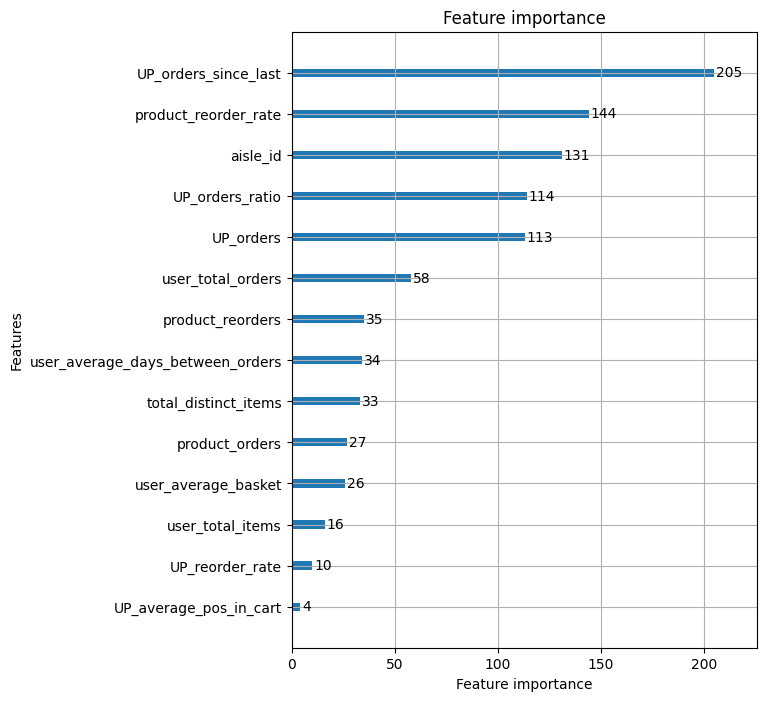

In [41]:
params = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": {"binary_logloss"},
    "num_leaves": 96,
    "max_depth": 10,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.95,
    "bagging_freq": 5,
}
rounds = 10

model = train_model(train_dataset, params, rounds)
model.save_model("./models/baseline")

Тестирование

In [ ]:
def make_submission(model, test_orders, orders, users, train, userXproduct, products):
    df_test_pairs, _ = get_all_pairs(
        test_orders, orders, users, train, drop_orders=False
    )

    df_test = get_all_features(df_test_pairs, orders, userXproduct, users, products)

    preds = model.predict(df_test)  # "вероятности"

    df_test_pairs["pred"] = preds

    TRESHOLD = 0.22  # guess, should be tuned with crossval on a subset of train data

    d = dict()
    for row in df_test_pairs.itertuples():
        if row.pred > TRESHOLD:
            try:
                d[row.order_id] += " " + str(row.product_id)
            except:  # noqa: E722
                d[row.order_id] = str(row.product_id)

    for order in test_orders.order_id:
        if order not in d:
            d[order] = "None"

    sub = pd.DataFrame.from_dict(d, orient="index")

    sub.reset_index(inplace=True)
    sub.columns = ["order_id", "products"]
    sub.to_csv("sub.csv", index=False)

In [65]:
make_submission(model, test_orders, orders, users, train, userXproduct, products)

order row 10000
order row 20000
order row 30000
order row 40000
order row 50000
order row 60000
order row 70000
Добавление фичей пользователя (из users)
Добавления фичей заказа (из orders)
Добавление фичей продукта (из products)
Добавление фичей пользователь-продукт (из userXproduct)


Инференс

In [21]:
def select_pairs(user_id: int, products: pd.DataFrame, n: int = 1000):
    selected_products = products.sort_values(by=["reorder_rate"])["product_id"][:n]

    df_pairs = pd.DataFrame({"user_id": n * [user_id], "product_id": selected_products})

    return df_pairs

In [22]:
class RecommendationModel:
    def __init__(
        self,
        recommendations_n: int = 10,
    ):
        self.recommendations_n = recommendations_n
        self.clf_model = lgb.Booster(model_file="./models/baseline")


    def predict(self, user_id):
        selected_pairs = select_pairs(user_id, products)
        features = get_all_features(selected_pairs, orders, userXproduct, users, products)
        preds = self.clf_model.predict(features)
        selected_pairs["preds"] = preds

        # Выбираем топ recommendations_n вероятностей продуктов
        recommended_products = selected_pairs.sort_values(by=["preds"], ascending=False)["product_id"][:self.recommendations_n]
        recommended_products = recommended_products.reset_index(drop=True)

        return recommended_products

In [23]:
rec_model = RecommendationModel()

In [24]:
recommended_products = rec_model.predict(user_id=1)
recommended_products

0    19755
1    33762
2     7133
3    33585
4     7000
5    18588
6    37058
7    35638
8    22777
9    47068
Name: product_id, dtype: uint16

In [25]:
user_id = 1

selected_pairs = select_pairs(user_id, products)
features = get_all_features(selected_pairs, orders, userXproduct, users, products)
features

,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,aisle_id,department_id,product_orders,product_reorders,product_reorder_rate,UP_orders,UP_orders_ratio,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last
product_id,,,,,,,,,,,,,,,
19856,11,59,18,19.0,5.363636,63,9,7,0.0,0.0,NaN,NaN,NaN,NaN,NaN
35859,11,59,18,19.0,5.363636,47,11,4,0.0,0.0,NaN,NaN,NaN,NaN,NaN
35856,11,59,18,19.0,5.363636,53,16,6,0.0,0.0,NaN,NaN,NaN,NaN,NaN
19848,11,59,18,19.0,5.363636,104,13,6,0.0,0.0,NaN,NaN,NaN,NaN,NaN
19838,11,59,18,19.0,5.363636,47,11,6,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32891,11,59,18,19.0,5.363636,105,13,4,0.0,0.0,NaN,NaN,NaN,NaN,NaN
24134,11,59,18,19.0,5.363636,133,11,6,0.0,0.0,NaN,NaN,NaN,NaN,NaN
24127,11,59,18,19.0,5.363636,65,11,4,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [239]:
user_id = 1000

selected_pairs = select_pairs(user_id, products)
features = get_all_features(selected_pairs, orders, userXproduct, users, products)
features

,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,aisle_id,department_id,product_orders,product_reorders,product_reorder_rate,UP_orders,UP_orders_ratio,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last
product_id,,,,,,,,,,,,,,,
19856,8,103,32,13.428572,12.875,63,9,7,0.0,0.0,NaN,NaN,NaN,NaN,NaN
35859,8,103,32,13.428572,12.875,47,11,4,0.0,0.0,NaN,NaN,NaN,NaN,NaN
35856,8,103,32,13.428572,12.875,53,16,6,0.0,0.0,NaN,NaN,NaN,NaN,NaN
19848,8,103,32,13.428572,12.875,104,13,6,0.0,0.0,NaN,NaN,NaN,NaN,NaN
19838,8,103,32,13.428572,12.875,47,11,6,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32891,8,103,32,13.428572,12.875,105,13,4,0.0,0.0,NaN,NaN,NaN,NaN,NaN
24134,8,103,32,13.428572,12.875,133,11,6,0.0,0.0,NaN,NaN,NaN,NaN,NaN
24127,8,103,32,13.428572,12.875,65,11,4,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
selected_pairs = select_pairs(user_id, products)
features = get_all_features(selected_pairs, orders, userXproduct, users, products)
preds = model.predict(features)
selected_pairs["preds"] = preds

# Выбираем топ recommendations_n вероятностей продуктов
recommended_products = selected_pairs.sort_values(by=["preds"], ascending=False)["product_id"][:self.recommendations_n]
recommended_products = recommended_products.reset_index(drop=True)

In [240]:
products

,product_id,aisle_id,department_id,orders,reorders,reorder_rate
product_id,,,,,,
1,1,61,19,1852.0,1136.0,0.613391
2,2,104,13,90.0,12.0,0.133333
3,3,94,7,277.0,203.0,0.732852
4,4,38,1,329.0,147.0,0.446809
5,5,5,13,15.0,9.0,0.600000
...,...,...,...,...,...,...
49684,49684,124,5,9.0,1.0,0.111111
49685,49685,42,1,49.0,6.0,0.122449
49686,49686,112,3,120.0,84.0,0.700000


In [241]:
userXproduct

,nb_orders,last_order_id,sum_pos_in_cart
-1246903360,5,104690,10
-1246907495,5,132412,16
-1246927153,1,2,3
-1246890562,5,2382766,24
-1246906445,3,2382766,14
...,...,...,...
-1770221987,1,3421083,2
-1770246134,1,3421083,3
-1770232085,1,3421083,5
-1770255944,1,3421083,7


In [242]:
users

,total_items,all_products,total_distinct_items,average_days_between_orders,nb_orders,average_basket
user_id,,,,,,
1,59,"{17122, 196, 26405, 46149, 14084, 13032, 26088...",18,19.000000,11,5.363636
2,195,"{45066, 2573, 18961, 23, 32792, 1559, 22559, 1...",102,16.285715,15,13.000000
3,88,"{17668, 44683, 48523, 21903, 14992, 21137, 324...",33,12.000000,13,6.769231
4,18,"{21573, 42329, 17769, 35469, 37646, 1200, 1905...",17,17.000000,6,3.000000
5,37,"{11777, 40706, 28289, 48775, 20754, 6808, 1398...",23,11.500000,5,7.400000
...,...,...,...,...,...,...
206205,32,"{20995, 21137, 22035, 21910, 17691, 31404, 210...",24,16.666666,4,8.000000
206206,285,"{16896, 44033, 18434, 16387, 21508, 45573, 102...",150,3.716418,68,4.191176
206207,223,"{20995, 18441, 45578, 47626, 33806, 22035, 235...",92,14.312500,17,13.117647
